In [1]:
# Tom's Functions

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import itertools
import warnings
from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [4]:
# Long-term monthly forecaster. Requires ./datasets/auckland_combo_2003-2023.csv
# Use this function for long-term monthly forecasts, e.g., what will the mean max temperature be in Auckland by January 2050?
# I used some code from this tutorial: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

# Parameters:
# 'feature' is the dataset column you want to forecast for, e.g., you want to predict 'Tmax(C)'
# 'dt' is the date and time you want to predict for, as a string in this format: '2050-01-01'

def monthly_forecaster(feature, dt):
    # preps dataframe
    query = pd.read_csv('./datasets/auckland_combo_2003-2023.csv')
    query = query[[feature,'Day(Local_Date)']]
    query = query.rename(columns={'Day(Local_Date)':'Date'})
    query[feature] = query[feature].replace('-',np.nan)
    query = query.fillna(query.bfill())
    query = query.set_index('Date')
    query.index = pd.to_datetime(query.index, format='%Y%m%d:%H%M')
    query = query.truncate(before='2003', after='2023')
    query[feature] = query[feature].astype('float')
    query = query.resample('MS').median()
    query_date = datetime.strptime(dt, '%Y-%m-%d')
    end_date = pd.to_datetime(query[feature].tail(1).index[0])
    start_date = pd.to_datetime(query[feature].head(1).index[0])

    if ((query_date - end_date).days < 0):
        print("\nQuery date is already in observed history. Pick a future date.")
        return

    query.plot(figsize=(20, 4), title="History", ylabel=feature)

    # generate different combinations of p, d and q triplets
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    print('\nComputing', feature, end='')
    aics = {'param':[], 'param_seasonal':[], 'score':[]}
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(query,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                print('.', end='')
                aics['param'].append(param)
                aics['param_seasonal'].append(param_seasonal)
                aics['score'].append(results.aic)
            except:
                continue

    print('\n\nCombination with best AIC score:')
    aics = pd.DataFrame(aics)
    aics = aics[aics.score > 0]
    print(aics[aics.score == min(aics.score)],'\n')
    param = aics[aics.score == min(aics.score)]['param'].iloc[0]
    param_seasonal = aics[aics.score == min(aics.score)]['param_seasonal'].iloc[0]

    # training model with optimal p d q combo
    mod = sm.tsa.statespace.SARIMAX(query,
                                    order=param,
                                    seasonal_order=param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])

    # comparing observations against predictions within same time range to calculate rmse
    pred_static = results.get_prediction(start=start_date, dynamic=False).predicted_mean
    pred_dynamic = results.get_prediction(start=start_date, dynamic=True).predicted_mean
    observed = query[feature]
    print('Static RMSE: ', np.mean((observed - pred_static) ** 2))
    print('Dynamic RMSE: ', np.mean((observed - pred_dynamic) ** 2))


    # Get forecast up to query_date in months
    days_between = (query_date - end_date).days

    # relativedelta code to convert days to months based on this answer on stackoverflow:
    # https://stackoverflow.com/questions/32083726/how-do-i-convert-days-into-years-and-months-in-python
    rdelta = relativedelta(query_date, end_date)
    stepz = abs(int((rdelta.years*12 + rdelta.months)))

    forecast = results.get_forecast(steps=stepz)
    forecast_ci = forecast.conf_int()

    plugging_hole = pd.DataFrame(forecast.predicted_mean.head(1)).rename(columns={'predicted_mean':feature})
    query = pd.concat([query, plugging_hole])

    ax = query.plot(label='observed', figsize=(20, 4), title='Forecast')
    forecast.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(forecast_ci.index,
                    forecast_ci.iloc[:, 0],
                    forecast_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(feature)
    ax.set_xlim([end_date - timedelta(days=5*365), query_date])
    ax.legend()

    # forecast results
    print('Forecast: ',round(forecast.predicted_mean[len(forecast.predicted_mean)-1], 2))
    print('End of dataset: ', round(query.tail(2)[feature][0],2))
    return round(forecast.predicted_mean[len(forecast.predicted_mean)-1], 2)


Computing Tmax(C)................................................................

Combination with best AIC score:
        param param_seasonal       score
59  (1, 1, 1)  (0, 1, 1, 12)  565.324155 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2682      0.079      3.413      0.001       0.114       0.422
ma.L1         -0.9870      0.046    -21.618      0.000      -1.076      -0.898
ma.S.L12      -1.0001    111.371     -0.009      0.993    -219.283     217.283
sigma2         0.6835     76.160      0.009      0.993    -148.588     149.955
Static RMSE:  3.838906980110431
Dynamic RMSE:  392.5193257261411
Forecast:  26.77
End of dataset:  22.9


26.77

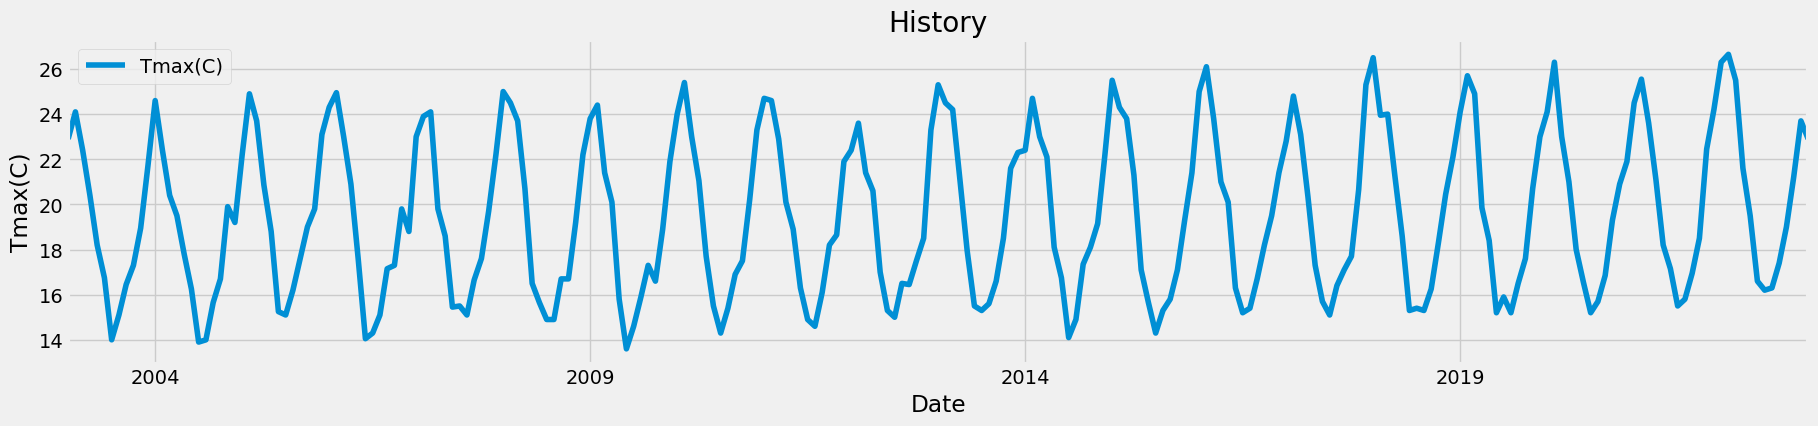

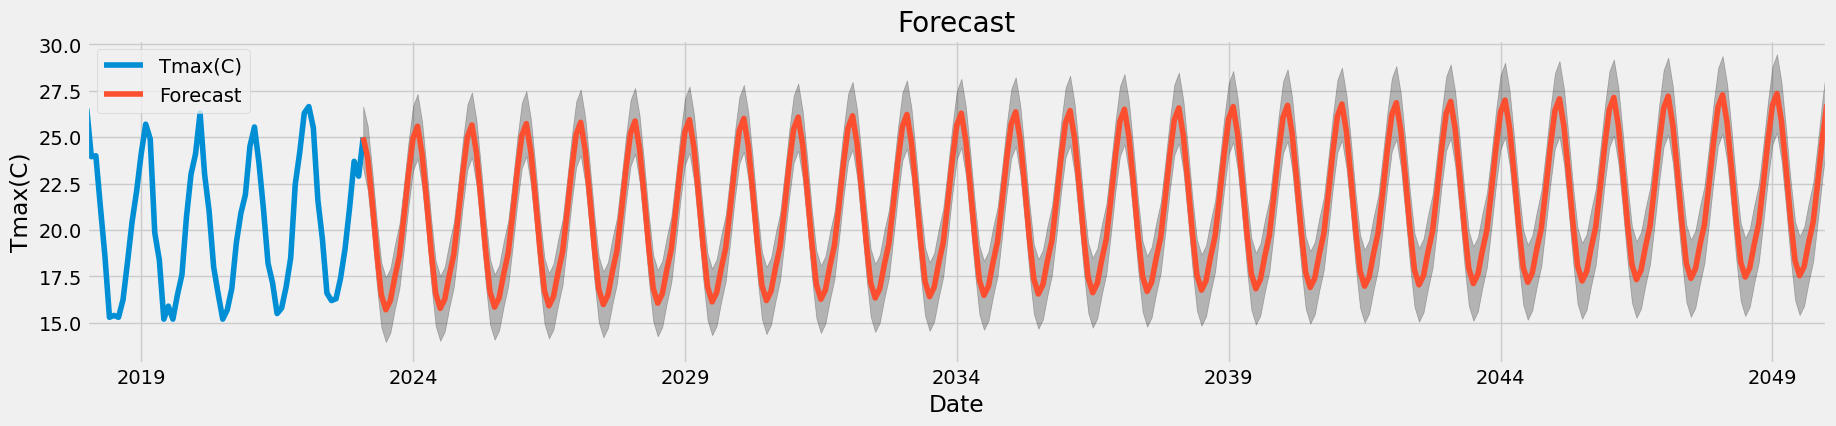

In [5]:
# Test case 1: What will the mean max temperature be in Auckland by 2050?
monthly_forecaster('Tmax(C)', '2050-01-01')

In [6]:
# Test case 2: what happens if I put in a value already in my dataset
monthly_forecaster('Tmax(C)', '2022-01-01')


Query date is already in observed history. Pick a future date.


In [7]:
# Short-term hourly forecaster. Requires ./datasets/auckland_classified_complete.csv
# Use this function for short term hourly forecasts, e.g., what will the temperature be tomorrow at 9am?
# I used some code from this tutorial: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

# Parameters:
# 'feature' is the dataset column you want to forecast for, e.g., you want to predict 'Temp(C)'
# 'dt' is the date and time you want to predict for, as a string in this format: '2022-07-10:0900'
# 'history_days' is how many days from the end of the dataset going back to train on.

def hourly_forecast(feature, dt, history_days):
    # merge date and time into one and set as index column
    query = pd.read_csv('./datasets/auckland_classified_complete.csv')
    query['datetime'] = pd.to_datetime(query['Date'].astype(str) + ' ' + query['Time'].astype(str))
    query = query.drop(['Date','Time'],axis=1)
    query = query.rename(columns={'datetime':'Date'})
    query = query.set_index('Date')

    # getting data prior to the forecast date; the amount of data is controlled by the window size parameter
    query = query[[feature]]
    query = query.resample('H').mean()
    query_date = datetime.strptime(dt, '%Y-%m-%d:%H%M')
    end_date = pd.to_datetime(query.tail(1).index[0])
    start_date = end_date - timedelta(history_days)
    if ((query_date - end_date).days < 0):
            print("\nQuery date is already in observed history. Pick a future date.")
            return

    filt = (query.index >= start_date) & (query.index <= end_date)
    query = query[filt]
    query.plot(figsize=(20, 4), title="History", ylabel=feature)

    # generate all different combinations of p, d and q triplets, find optimal combination (ie produces a model with lowest AIC)
    p = d = q = range(0, 5)
    pdq = list(itertools.product(p, d, q))
    print('\nComputing', feature, end='')
    aics = {'param':[], 'score':[]}
    for param in pdq:    
        try:
            mod = ARIMA(query[feature], order=param)
            results = mod.fit()
            print('.', end='')
            aics['param'].append(param)
            aics['score'].append(results.aic)
        except:
            continue

    aics = pd.DataFrame(aics)
    aics = aics[aics.score > 0]
    print('\n\nCombination with best AIC score:')
    print(aics[aics.score == min(aics.score)],'\n')
    param = aics[aics.score == min(aics.score)]['param'].iloc[0]

    # training model with optimal p d q combo
    mod = ARIMA(query[feature], order=param)
    results = mod.fit()
    print(results.summary().tables[1])

    # comparing observations against predictions within same time range to calculate rmse
    pred_static = results.get_prediction(start=start_date, dynamic=False).predicted_mean
    pred_dynamic = results.get_prediction(start=start_date, dynamic=True).predicted_mean
    observed = query[feature]
    print('Static RMSE: ', np.mean((observed - pred_static) ** 2))
    print('Dynamic RMSE: ', np.mean((observed - pred_dynamic) ** 2))

    # get forecast for however many hours ahead of the end of the dataset
    hours = abs(int((query_date - end_date).seconds / 60 / 60))
    days_hours = abs(int((query_date - end_date).days) * 24)
    stepz = hours + days_hours
    forecast = results.get_forecast(steps=stepz)
    forecast_ci = forecast.conf_int()

    # plots the forecast
    plugging_hole = pd.DataFrame(forecast.predicted_mean.head(1)).rename(columns={'predicted_mean':feature})
    query = pd.concat([query, plugging_hole])
    ax = query.plot(label='observed', figsize=(20, 4), title='Forecast')
    forecast.predicted_mean.plot(ax = ax, label='Forecast', figsize=(20, 3), title='Forecast')
    ax.fill_between(forecast_ci.index,
                    forecast_ci.iloc[:, 0],
                    forecast_ci.iloc[:, 1], color='k', alpha=.25)

    ax.set_xlabel('Date')
    ax.set_ylabel(feature)
    ax.set_xlim([end_date - timedelta(days=1), query_date])
    ax.legend()

    # forecast results
    print('Forecast: ', round(forecast.predicted_mean[len(forecast.predicted_mean)-1],2))
    print('End of set: ', round(query.tail(2)[feature][0],2))
    return round(forecast.predicted_mean[len(forecast.predicted_mean)-1],2)


Computing Temp(C).............................................................................................................................

Combination with best AIC score:
         param       score
109  (4, 1, 4)  392.097028 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8544      0.070     26.393      0.000       1.717       1.992
ar.L2         -1.6871      0.110    -15.340      0.000      -1.903      -1.472
ar.L3          1.5067      0.110     13.660      0.000       1.291       1.723
ar.L4         -0.7862      0.060    -13.106      0.000      -0.904      -0.669
ma.L1         -1.8177      0.083    -21.787      0.000      -1.981      -1.654
ma.L2          1.7893      0.087     20.588      0.000       1.619       1.960
ma.L3         -1.7562      0.080    -21.956      0.000      -1.913      -1.599
ma.L4          0.8421      0.070     12.065      0.000 

12.49

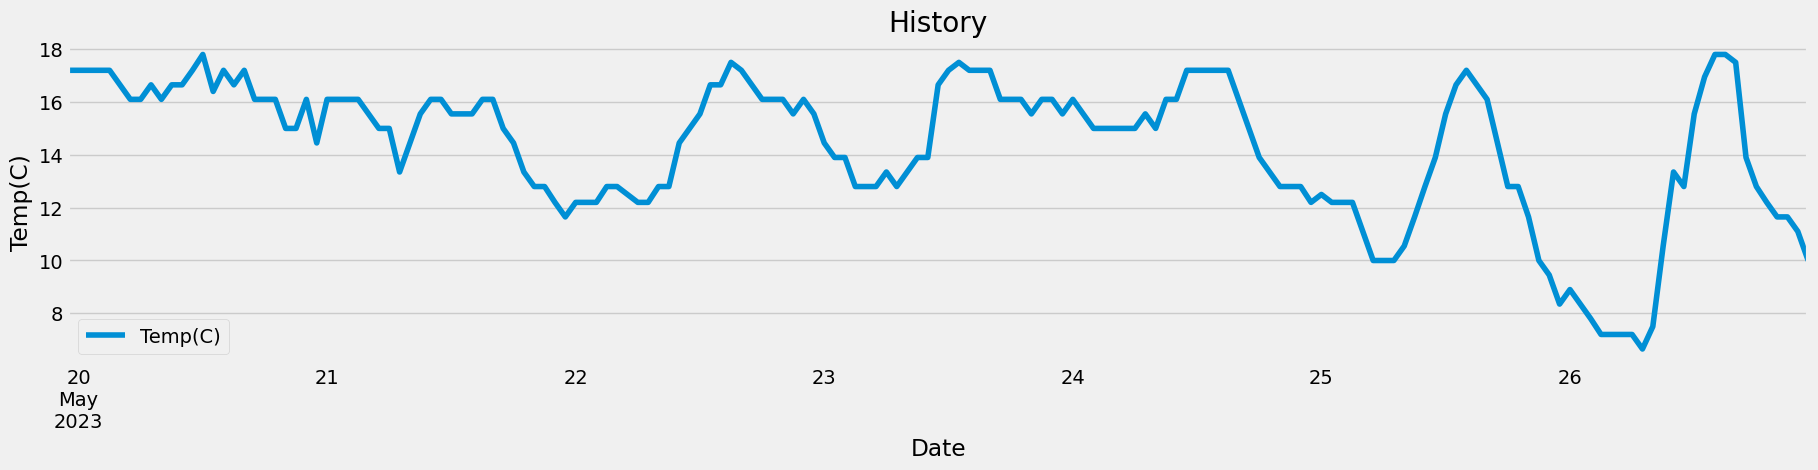

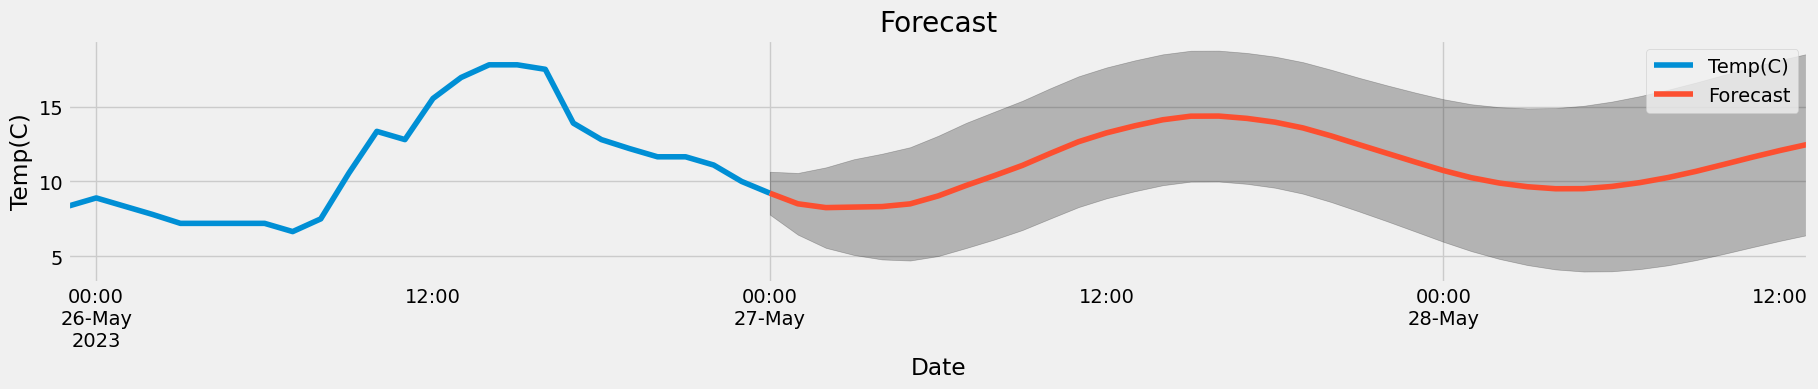

In [8]:
# Test case 1: I want to predict the temperature on 28 May 2023 at 1pm, based on 7 days of observations from end of set
hourly_forecast('Temp(C)', '2023-05-28:1300', 7)

In [9]:
# Test case 2: I want to predict a day already in the dataset, should fail
hourly_forecast('Temp(C)', '2022-05-28:1300', 7)


Query date is already in observed history. Pick a future date.


In [10]:
# Mid-term daily forecaster. Requires ./datasets/auckland_classified_complete.csv
# Use this function for daily forecasts, e.g., what will the mean temperature for tomorrow be?
# I used some code from this tutorial: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

# Parameters:
# 'feature' is the dataset column you want to forecast for, e.g., you want to predict 'Temp(C)'
# 'dt' is the date you want to predict for, as a string in this format: '2022-07-10'
# 'history_days' is how many days prior to day of prediction you want the model to train on, e.g., 30

def daily_forecast(feature, dt, history_days):
    # trimming down the classified set to dates from end to end - history_days
    query = pd.read_csv('./datasets/auckland_classified_complete.csv')
    query['datetime'] = pd.to_datetime(query['Date'].astype(str) + ' ' + query['Time'].astype(str))
    query = query.drop(['Date','Time'],axis=1)
    query = query.rename(columns={'datetime':'Date'})
    query = query.set_index('Date')
    query = query[[feature]]
    query = query.resample('D').mean()
    query_date = datetime.strptime(dt, '%Y-%m-%d')
    end_date = pd.to_datetime(query.tail(1).index[0])
    start_date = end_date - timedelta(history_days)
    
    if ((query_date - end_date).days < 0):
        print("\nQuery date is already in observed history. Pick a future date.")
        return

    filt = (query.index >= start_date) & (query.index <= end_date)
    query = query[filt]
    query.plot(figsize=(20, 4), title="History", ylabel=feature)

    # generate different combinations of p, d and q triplets, find optimal combination (ie produces a model with lowest AIC)
    p = d = q = range(0, 5)
    pdq = list(itertools.product(p, d, q))
    print('\nComputing', feature, end='')
    aics = {'param':[], 'score':[]}
    for param in pdq:    
        try:
            mod = ARIMA(query[feature], order=param)
            results = mod.fit()
            print('.', end='')
            aics['param'].append(param)
            aics['score'].append(results.aic)
        except:
            continue

    aics = pd.DataFrame(aics)
    aics = aics[aics.score > 0]
    print('\n\nCombination with best AIC score:')
    print(aics[aics.score == min(aics.score)], '\n')
    param = aics[aics.score == min(aics.score)]['param'].iloc[0]

    # training model with optimal p d q combo
    mod = ARIMA(query[feature], order=param)
    results = mod.fit()
    print(results.summary().tables[1])

    # comparing observations against predictions within same time range to calculate rmse
    pred_static = results.get_prediction(start=start_date, dynamic=False).predicted_mean
    pred_dynamic = results.get_prediction(start=start_date, dynamic=True).predicted_mean
    observed = query[feature]
    print('Static RMSE: ', np.mean((observed - pred_static) ** 2))
    print('Dynamic RMSE: ', np.mean((observed - pred_dynamic) ** 2))    

    # get forecast for however many days ahead and plot    
    stepz = (query_date - end_date).days
    if (stepz < 0):
        print("\nQuery date is already in observed history. Pick a future date.")
        return

    forecast = results.get_forecast(steps=stepz)
    forecast_ci = forecast.conf_int()

    # plots the forecast
    plugging_hole = pd.DataFrame(forecast.predicted_mean.head(1)).rename(columns={'predicted_mean':feature})
    query = pd.concat([query, plugging_hole])
    ax = query.plot(label='observed', figsize=(20, 4), title='Forecast')
    forecast.predicted_mean.plot(ax = ax, label='Forecast', figsize=(20, 3), title='Forecast')
    ax.fill_between(forecast_ci.index,
                    forecast_ci.iloc[:, 0],
                    forecast_ci.iloc[:, 1], color='k', alpha=.25)

    ax.set_xlabel('Date')
    ax.set_ylabel(feature)
    ax.set_xlim([end_date, query_date])
    ax.legend()

    print('Forecast: ',round(forecast.predicted_mean[len(forecast.predicted_mean)-1],2))
    print('End of set: ', round(query.tail(2)[feature][0],2))
    return round(forecast.predicted_mean[len(forecast.predicted_mean)-1],2)


Computing Temp(C).............................................................................................................................

Combination with best AIC score:
        param       score
57  (2, 1, 2)  108.978084 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4658      0.186      2.505      0.012       0.101       0.830
ar.L2         -0.9460      0.132     -7.164      0.000      -1.205      -0.687
ma.L1         -0.2199      4.276     -0.051      0.959      -8.600       8.160
ma.L2          0.9991     38.835      0.026      0.979     -75.116      77.115
sigma2         1.3553     52.494      0.026      0.979    -101.531     104.242
Static RMSE:  10.978234041409172
Dynamic RMSE:  254.03815332997968
Forecast:  12.82
End of set:  11.43


12.82

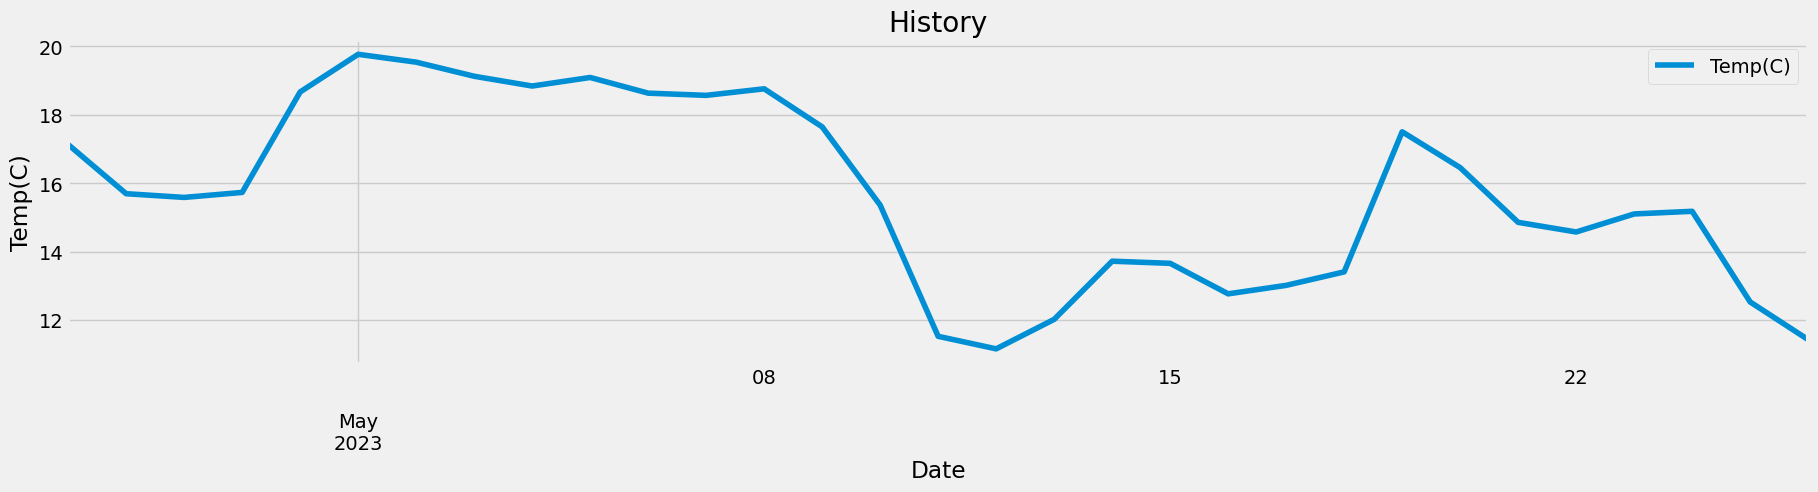

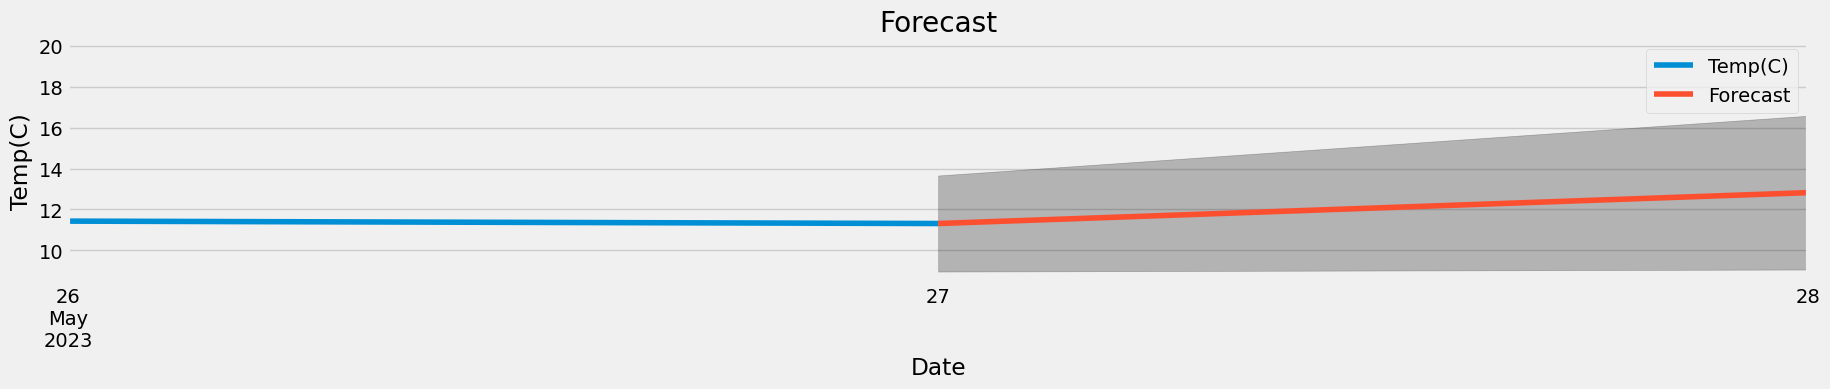

In [11]:
#Test case #1: I want to forecast the mean temperature for May 28 2023, based on 30 days of observations from end of set
daily_forecast('Temp(C)', '2023-05-28', 30)

In [12]:
# Test case 2: I want to predict a day already in the set, should fail
daily_forecast('Temp(C)', '2022-07-10', 90)


Query date is already in observed history. Pick a future date.


In [15]:
# Short-term condition forecaster. Requires ./datasets/auckland_classified_complete.csv
# Use this function for short term condition forecasts, e.g., what will the condition be tomorrow at 9am?
# Some of the K-Folds Cross Validation code here, also used in last assignment, was based on https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/

# Parameters:
# 'dt' is the date and time you want to predict for, as a string in this format: '2022-07-10:0900'
# 'history_days' is how many days from the end of the dataset going back to train on.

def hourly_forecast_condition(dt, history_days):
    temp = hourly_forecast('Temp(C)', dt, history_days)
    dew = hourly_forecast('DewPoint(C)', dt, history_days)
    humidity = hourly_forecast('Humidity(%)', dt, history_days)
    windspeed = hourly_forecast('WindSpeed(m/s)', dt, history_days)
    windgust = hourly_forecast('WindGust(m/s)', dt, history_days)
    pressure = hourly_forecast('Pressure(hPa)', dt, history_days)
    precipitation = hourly_forecast('Precipitation(mm)', dt, history_days)
    
    df_query = pd.read_csv('./datasets/auckland_classified_complete.csv')
    df_query = df_query.drop(['Date','Time','Wind'], axis = 1)
    df_query = df_query.convert_dtypes()
    df_query = df_query.dropna().reset_index(drop=True)

    X = df_query.drop('Condition',axis=1).to_numpy(dtype=float)
    y = df_query['Condition']
    X_scaler = preprocessing.RobustScaler().fit(X)
    X_scaled = X_scaler.transform(X)

    # scaled model performance
    model_s = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
    evaluator_s = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)
    evaluations_s = []

    for train_index, forecast_index in evaluator_s.split(X_scaled, y):    
        X_train_fold, X_forecast_fold = X_scaled[train_index], X_scaled[forecast_index]
        y_train_fold, y_forecast_fold = y[train_index], y[forecast_index]
        model_s.fit(X_train_fold, y_train_fold)
        evaluations_s.append(model_s.score(X_forecast_fold, y_forecast_fold))

    print('\n-- scaled --')
    print('upper accuracy: ', np.max(evaluations_s)*100, '%')
    print('lower accuracy: ', np.min(evaluations_s)*100, '%')
    print('mean accuracy: ', np.mean(evaluations_s)*100, '%')
    print('SD: ', np.std(evaluations_s))
    
    forecast = {
        'Temp(C)':[temp],
        'DewPoint(C)':[dew],
        'Humidity(%)':[humidity],
        'WindSpeed(m/s)':[windspeed],
        'WindGust(m/s)':[windgust],
        'Pressure(hPa)':[pressure],
        'Precipitation(mm)':[precipitation]
    }

    forecast = pd.DataFrame(forecast)
    forecast = forecast.assign(Predicted_Scaled = lambda row: model_s.predict(
        row[['Temp(C)','DewPoint(C)','Humidity(%)','WindSpeed(m/s)','WindGust(m/s)','Pressure(hPa)','Precipitation(mm)']]))
    
    print('\nForecast: ',forecast['Predicted_Scaled'][0])
    return forecast['Predicted_Scaled'][0]


Computing Temp(C).............................................................................................................................

Combination with best AIC score:
         param       score
109  (4, 1, 4)  392.097028 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8544      0.070     26.393      0.000       1.717       1.992
ar.L2         -1.6871      0.110    -15.340      0.000      -1.903      -1.472
ar.L3          1.5067      0.110     13.660      0.000       1.291       1.723
ar.L4         -0.7862      0.060    -13.106      0.000      -0.904      -0.669
ma.L1         -1.8177      0.083    -21.787      0.000      -1.981      -1.654
ma.L2          1.7893      0.087     20.588      0.000       1.619       1.960
ma.L3         -1.7562      0.080    -21.956      0.000      -1.913      -1.599
ma.L4          0.8421      0.070     12.065      0.000 

'Cloudy'

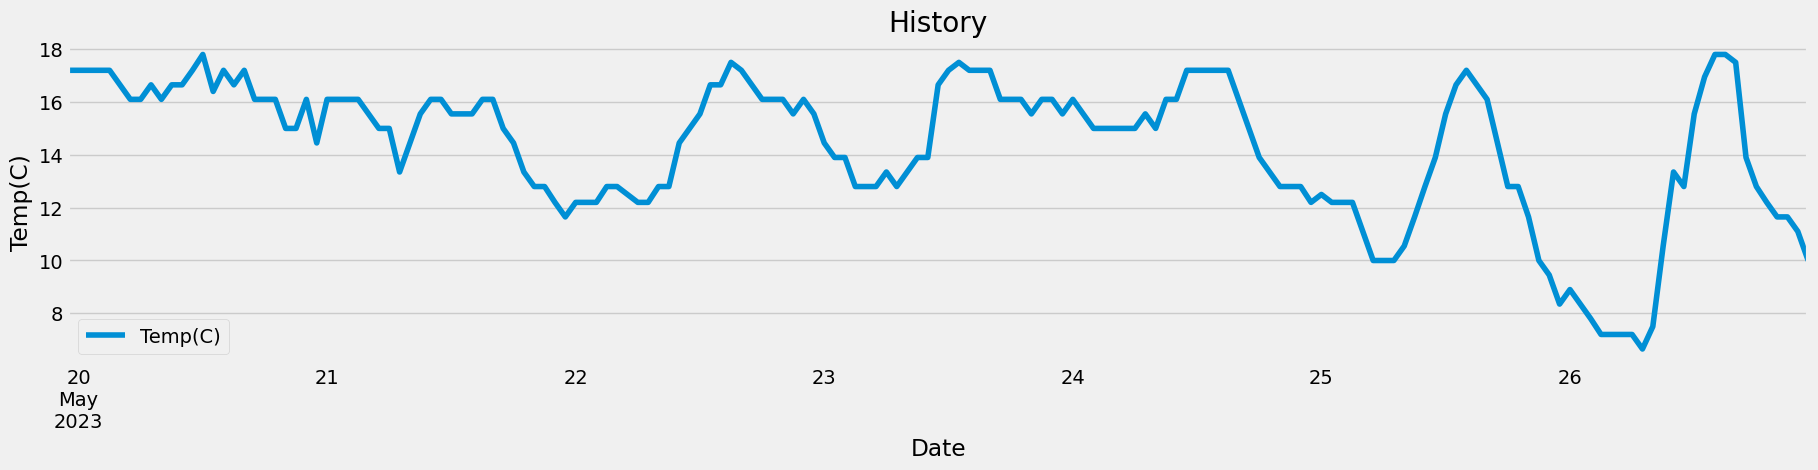

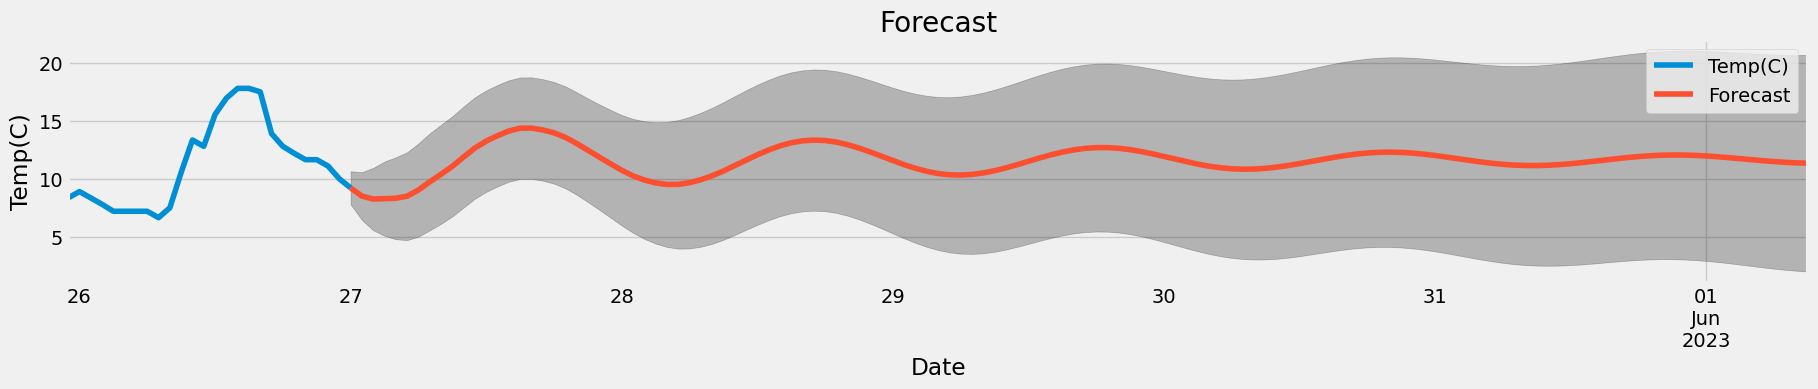

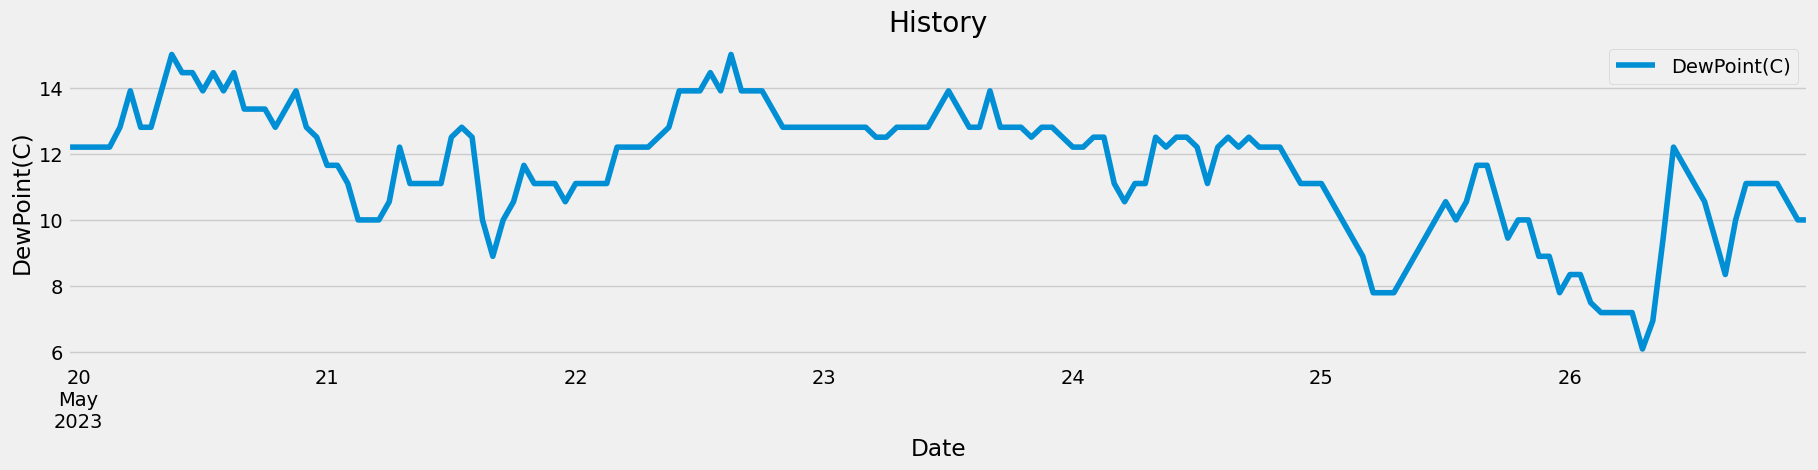

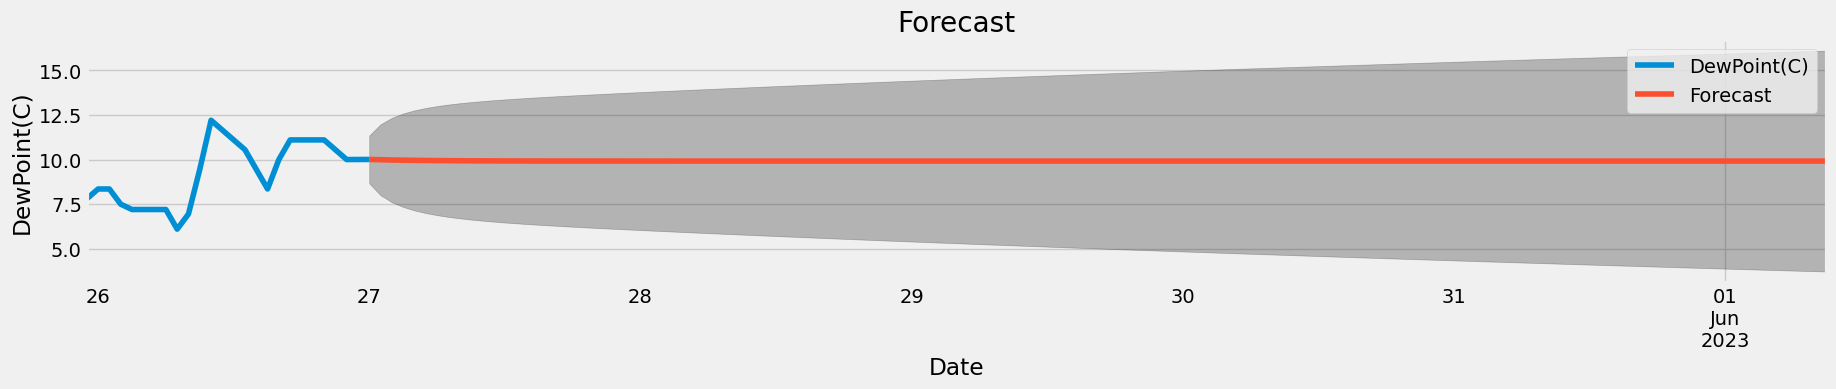

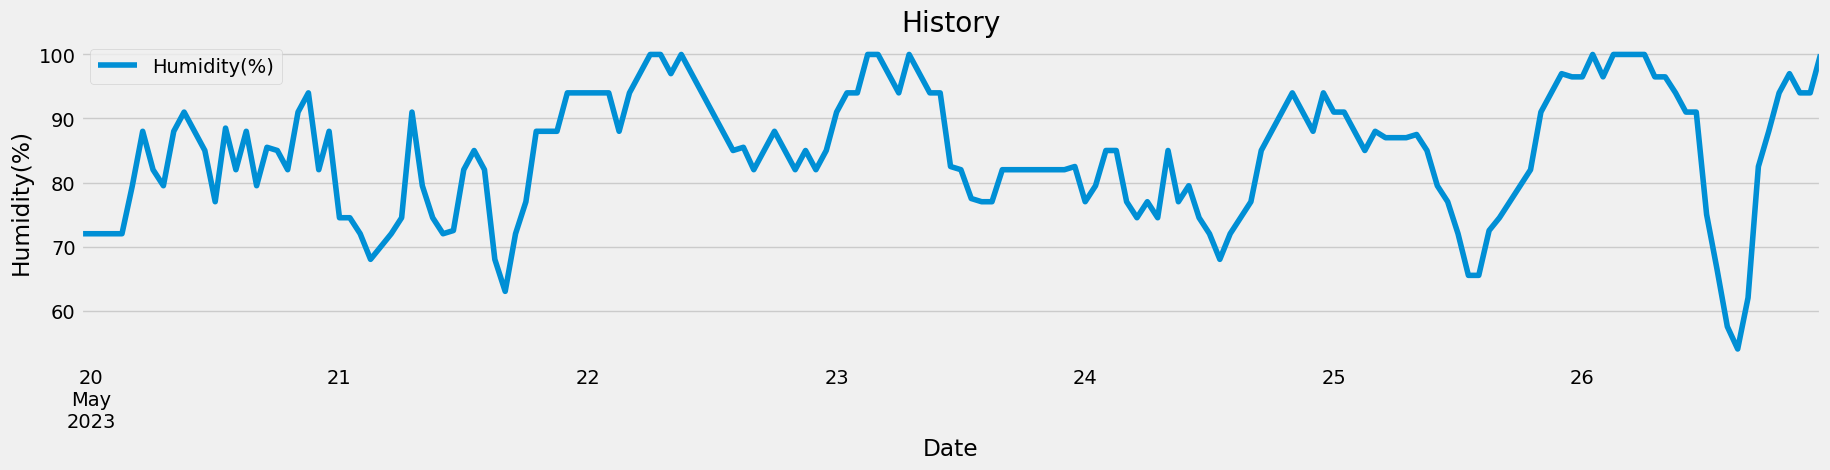

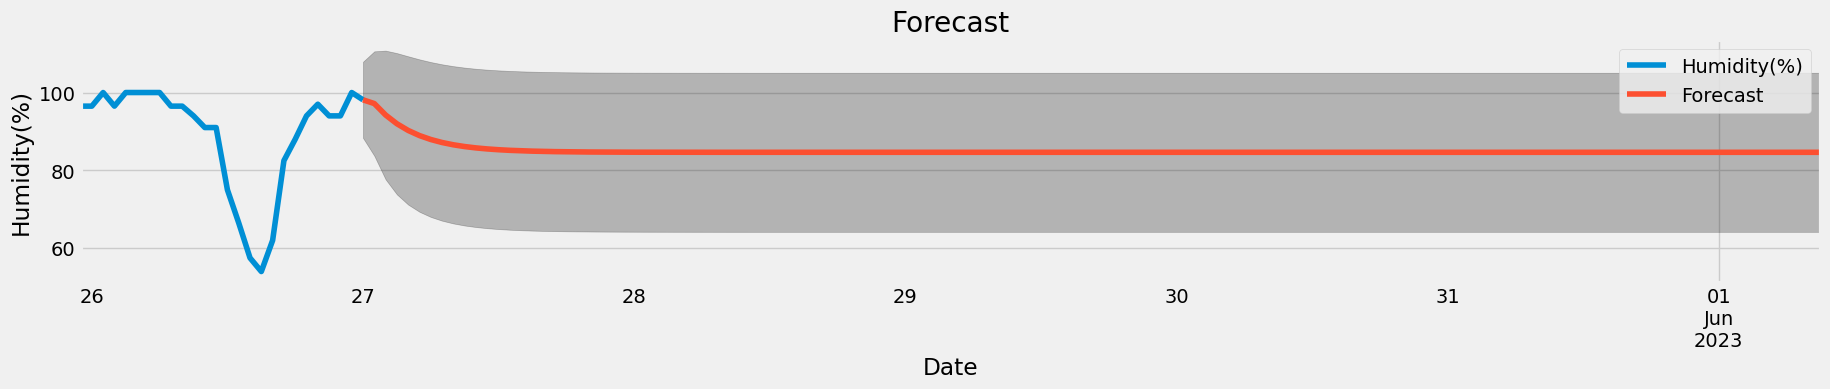

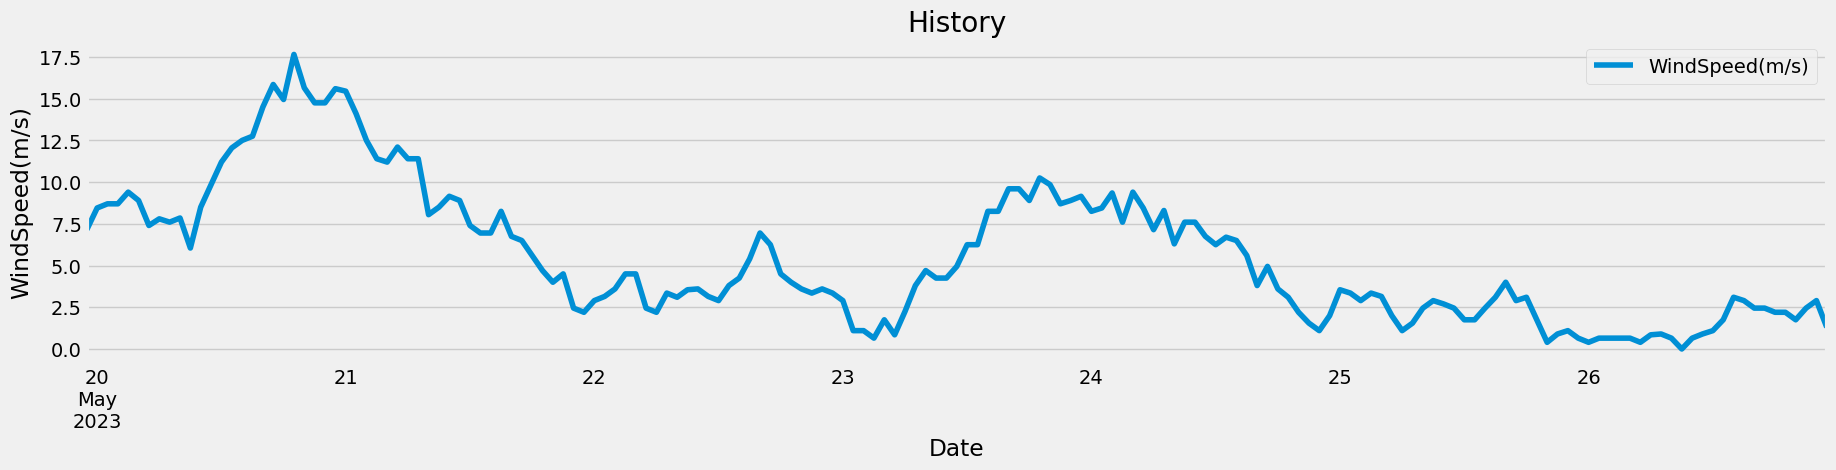

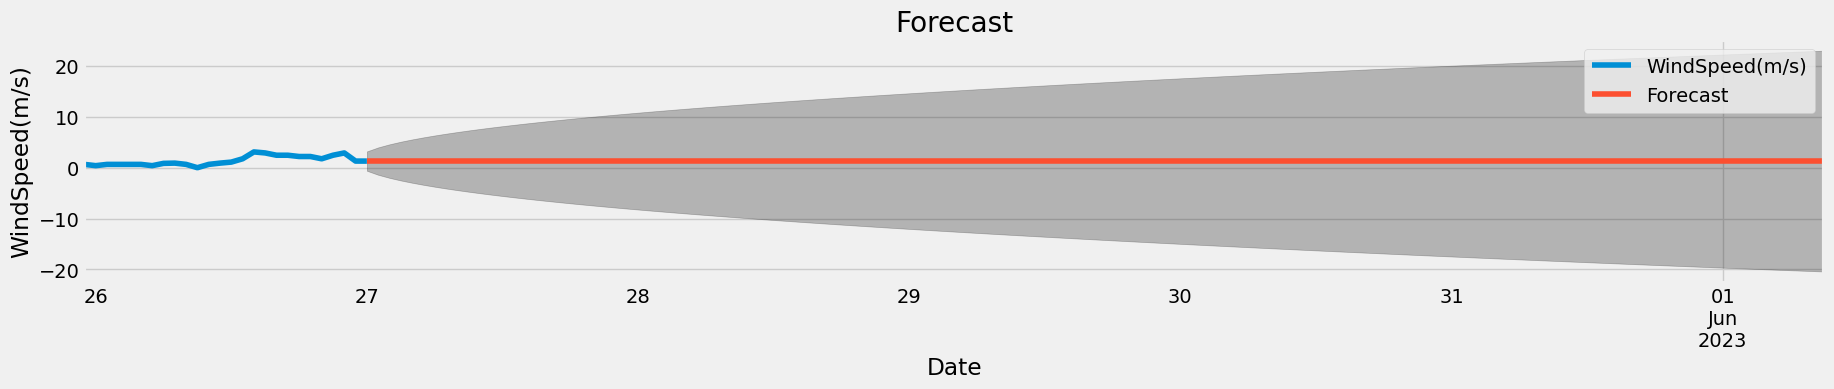

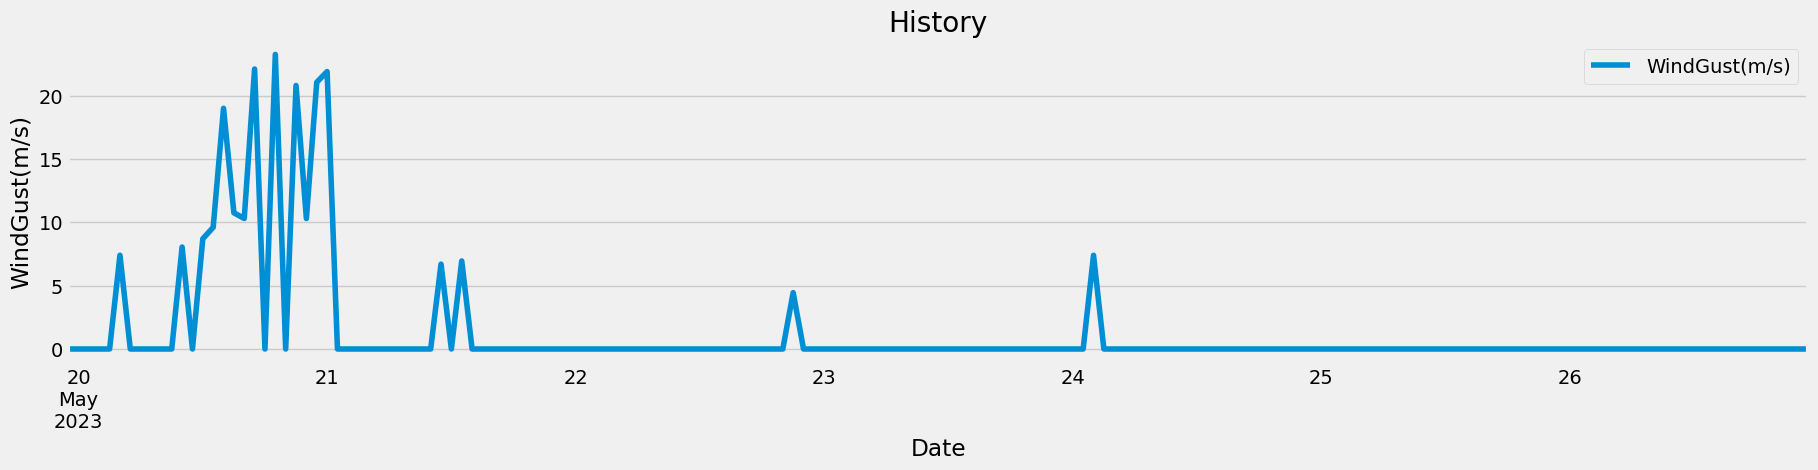

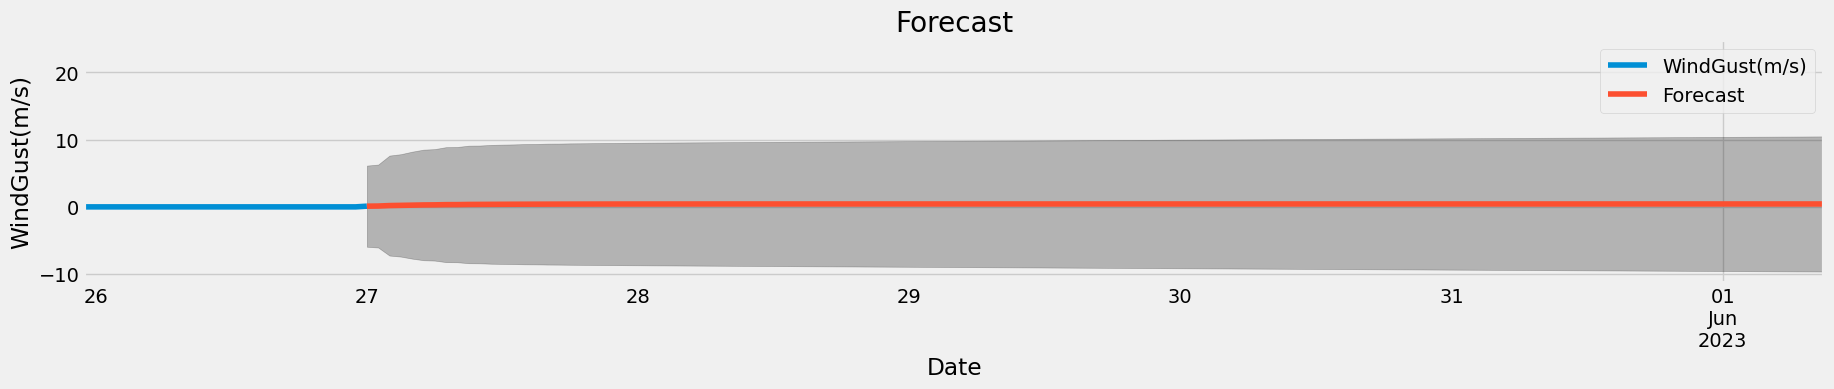

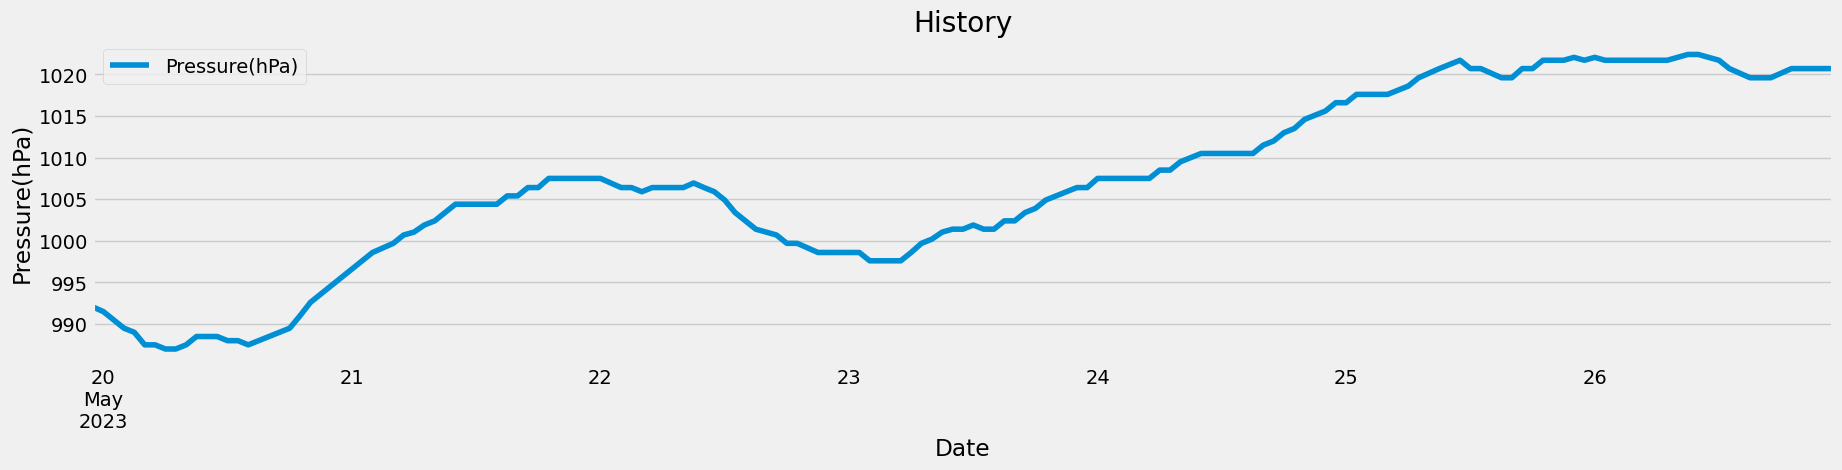

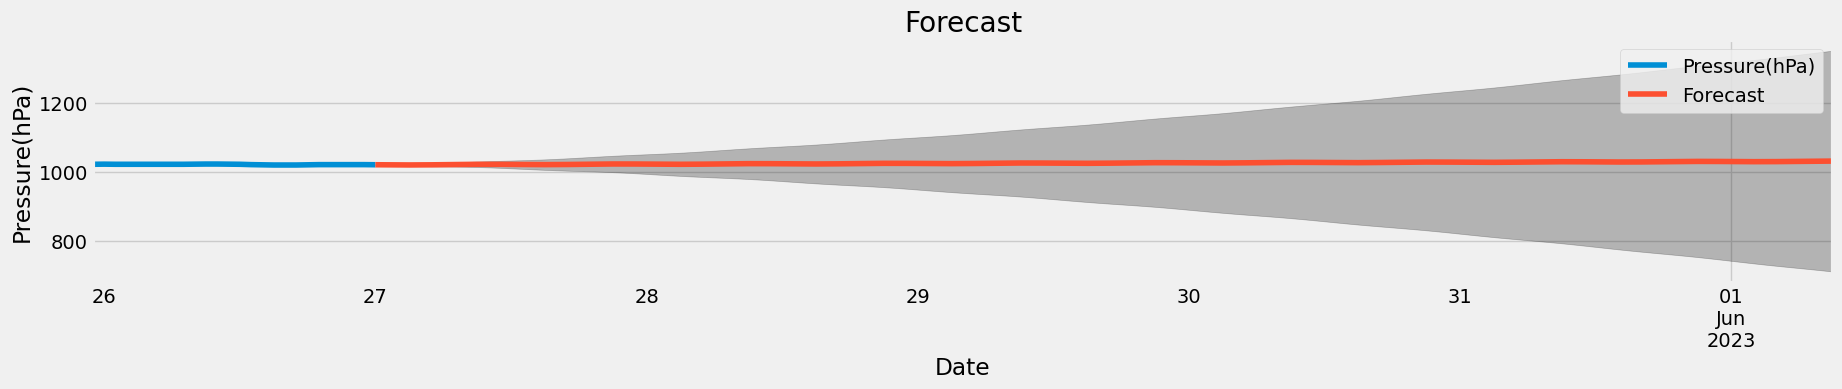

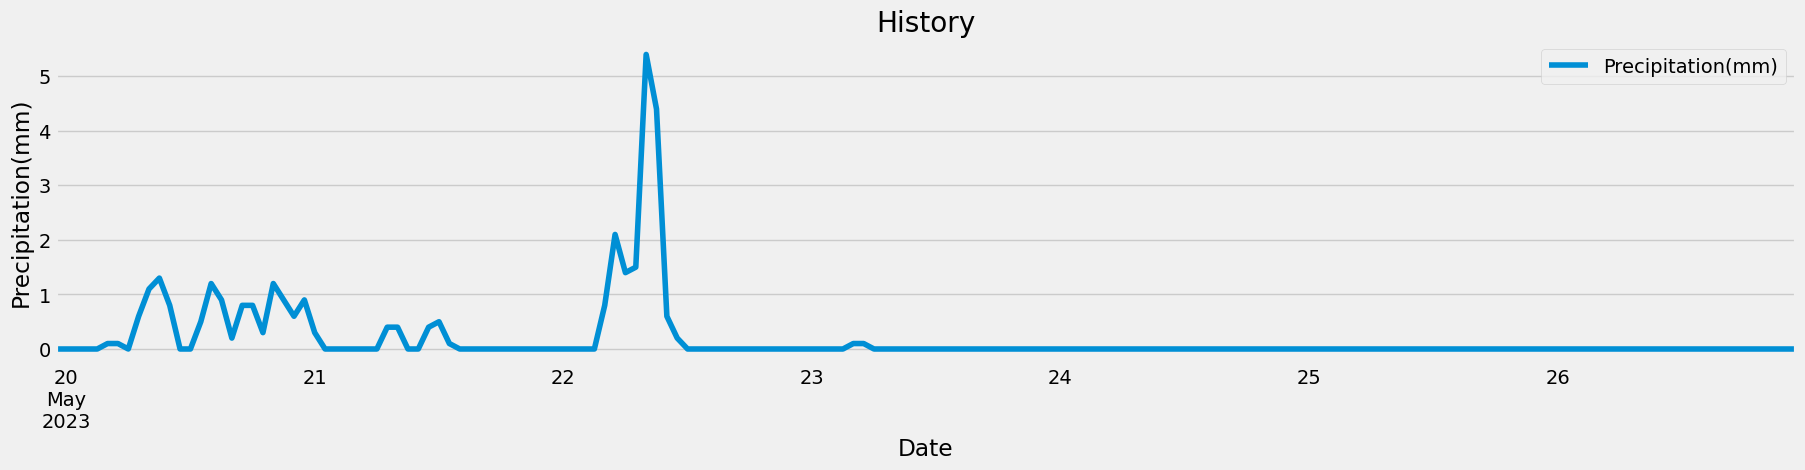

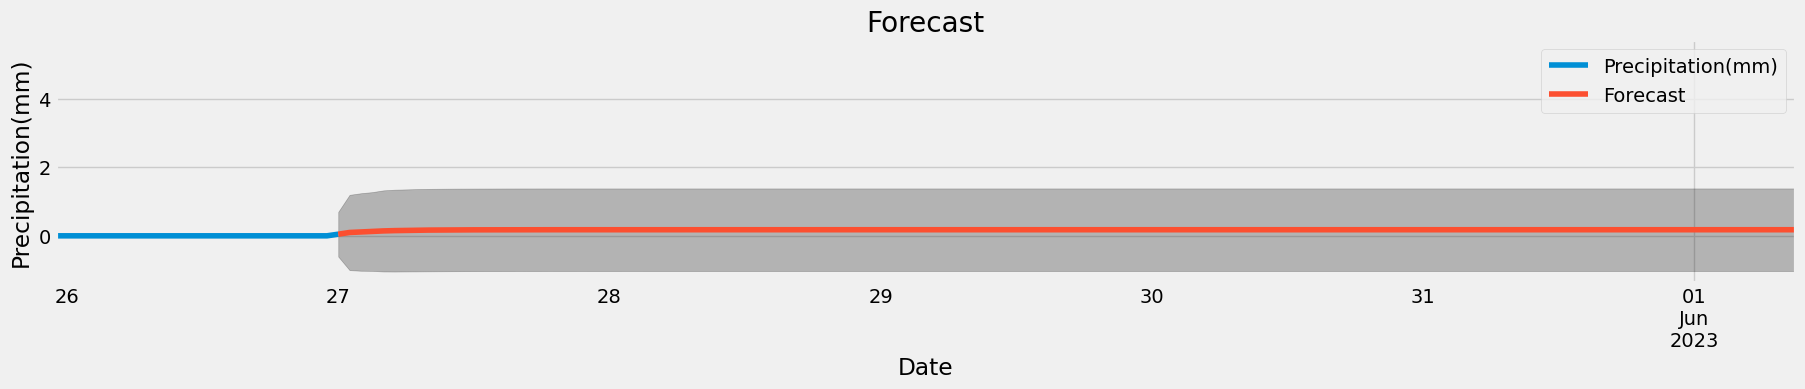

In [16]:
# Test case: what kind of weather will there be in Auckland on June 1st 9am, based on the last 7 days in the dataset?
hourly_forecast_condition('2023-06-01:0900', 7)